In [1]:
from influxdb_client import InfluxDBClient
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random

In [2]:
#Auth parameters
my_token = "yaKfFeAsha8tNAZxvYeZBMmq-khO8tz-6Ut_PARgohiWzeW2j8BB86ND33Qbq7hR8bylmOROPQAUr-7M103_Yw=="
my_org = "iot-org"
bucket = "iot-demo"
client = InfluxDBClient(url="http://192.168.1.100:9999", token=my_token, org=my_org, debug=False)

In [3]:
days = '9d'
n_days = 9

queryTemperature = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "temperature")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 5m, fn: median)
  ''' % days

queryHumidity = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "humidity")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 5m, fn: median)
  ''' % days

queryPressure = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "pressure")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 5m, fn: median)
  ''' % days



In [4]:
#Query InfluxDB and return a Dataframe
dfTemp = client.query_api().query_data_frame(org=my_org, query=queryTemperature)
dfHum = client.query_api().query_data_frame(org=my_org, query=queryHumidity)
dfPress = client.query_api().query_data_frame(org=my_org, query=queryPressure)

In [5]:
df = pd.DataFrame(dfTemp['_time']).rename(columns={'_time':'time'})
df['temperature'] = dfTemp['_value']
df['humidity'] = dfHum['_value']
df['pressure'] = dfPress['_value']
df = df.set_index('time')
df = df.asfreq(freq='300S')
df.head()

,temperature,humidity,pressure
time,,,
2020-07-07 12:30:00+00:00,29.40,46.40,NaN
2020-07-07 12:35:00+00:00,NaN,46.15,NaN
2020-07-07 12:40:00+00:00,29.45,45.80,NaN
2020-07-07 12:45:00+00:00,29.45,45.40,NaN
2020-07-07 12:50:00+00:00,29.45,45.20,1019.5


In [6]:
print(df['temperature'].isnull().sum())
print(df['humidity'].isnull().sum())
print(df['pressure'].isnull().sum())

286
44
1894


In [7]:
df['temperature'] = df['temperature'].fillna(method='backfill').fillna(method='ffill')
df['humidity'] = df['humidity'].fillna(method='backfill').fillna(method='ffill')
df['pressure'] = df['pressure'].fillna(method='backfill').fillna(method='ffill')

In [8]:
points_per_day = int(len(df)/n_days) 
points_per_day

288

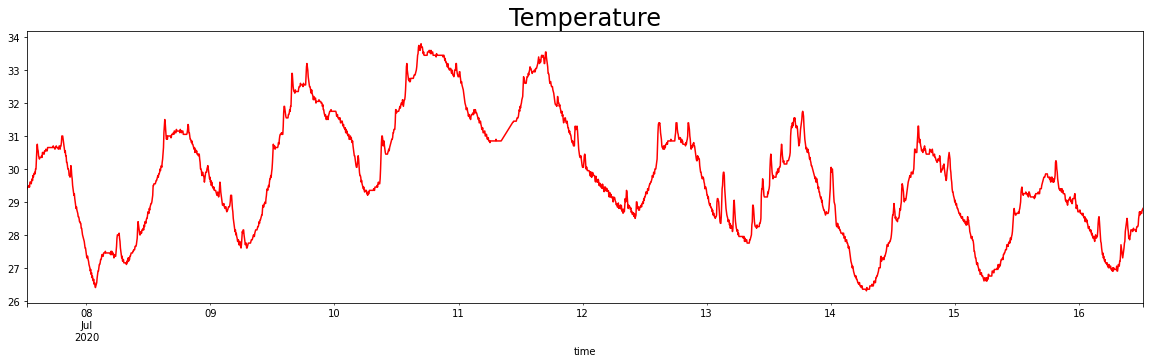

In [9]:
df.temperature.plot(figsize = (20,5), color = "red")
plt.title("Temperature", size = 24)
plt.show()                          

In [10]:
size = len(df)-points_per_day
df_train, df_test = df.iloc[:size], df.iloc[size:]

end_pred = 12#int(points_per_day/12)

start_date = df_test.index[0]
end_date = df_test.index[end_pred]

# Temperature

In [46]:
# fit model
model = ExponentialSmoothing(df_train.temperature, seasonal="add",seasonal_periods = 288)#trend = "add")#, seasonal = "mul", seasonal_periods=500)
model_fit = model.fit()#optimized=True)#, use_boxcox=True, remove_bias=True)

print(model_fit.summary())

df_forecast = model_fit.forecast(end_pred)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2304
Model:             ExponentialSmoothing   SSE                             26.102
Optimized:                         True   AIC                          -9742.798
Trend:                             None   BIC                          -8077.502
Seasonal:                      Additive   AICC                         -9657.710
Seasonal Periods:                   288   Date:                 Thu, 16 Jul 2020
Box-Cox:                          False   Time:                         14:40:45
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.8947368                alpha                 True
smoothing_seasonal    

/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


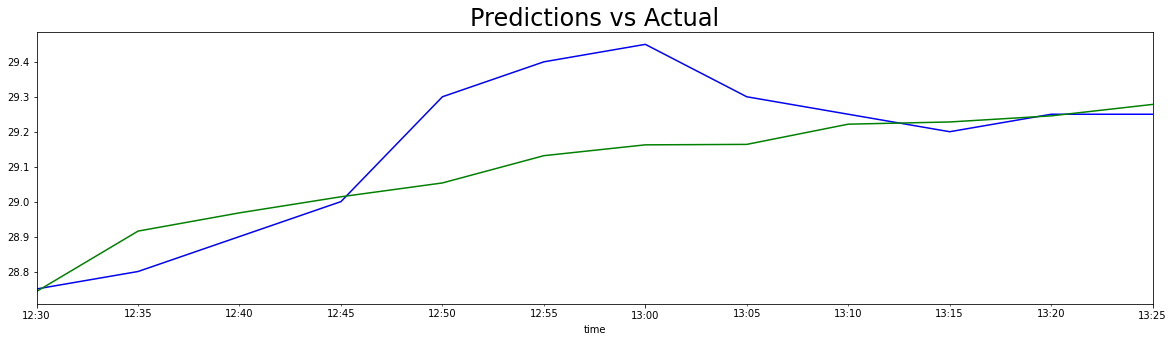

ABSOLUTE ERROR 0.10270462450199513
MSE 0.021233449034994138


In [48]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[:end_pred].plot(figsize = (20,5),color = "blue")
df_forecast.plot(color = "green")
plt.title("Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.temperature[:end_pred], df_forecast)))
print("MSE "+str(mean_squared_error(df_test.temperature[:end_pred], df_forecast)))

# Humidity

In [49]:
# fit model
model = ExponentialSmoothing(df_train.humidity, trend="mul")# seasonal="mul",seasonal_periods = 288)
model_fit = model.fit()

print(model_fit.summary())

df_forecast = model_fit.forecast(end_pred)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2304
Model:             ExponentialSmoothing   SSE                             82.848
Optimized:                         True   AIC                          -7653.703
Trend:                   Multiplicative   BIC                          -7630.733
Seasonal:                          None   AICC                         -7653.666
Seasonal Periods:                  None   Date:                 Thu, 16 Jul 2020
Box-Cox:                          False   Time:                         14:41:00
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_slope            0.46132

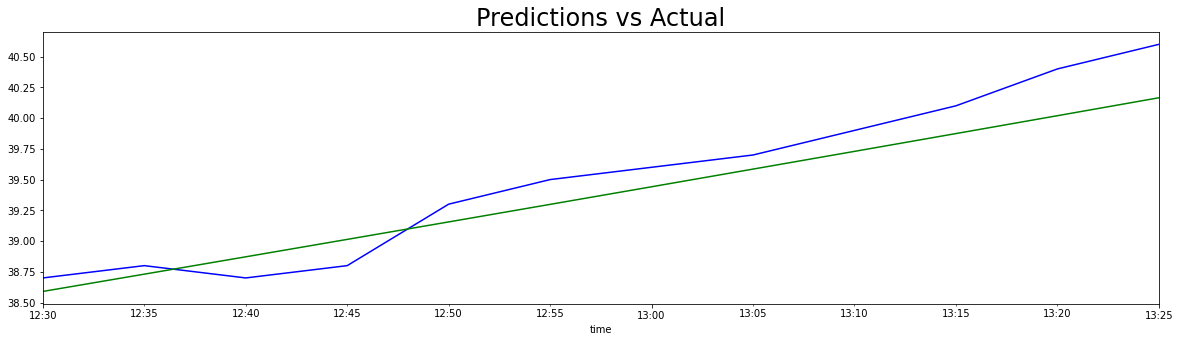

ABSOLUTE ERROR 0.19957435214552888
MSE 0.05044598216958194


In [50]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[:end_pred].plot(figsize = (20,5),color = "blue")
df_forecast.plot(color = "green")
plt.title("Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.humidity[:end_pred], df_forecast)))
print("MSE "+str(mean_squared_error(df_test.humidity[:end_pred], df_forecast)))

# Pressure

In [51]:
# fit model
model = ExponentialSmoothing(df_train.pressure)#, seasonal="add",seasonal_periods = 288) #seasonal = "mul", seasonal_periods=288)
model_fit = model.fit()

print(model_fit.summary())

df_forecast = model_fit.forecast(end_pred)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2304
Model:             ExponentialSmoothing   SSE                             81.037
Optimized:                         True   AIC                          -7708.630
Trend:                             None   BIC                          -7697.145
Seasonal:                          None   AICC                         -7708.612
Seasonal Periods:                  None   Date:                 Thu, 16 Jul 2020
Box-Cox:                          False   Time:                         14:41:06
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.7841953                alpha                 True
initial_level              1019.50

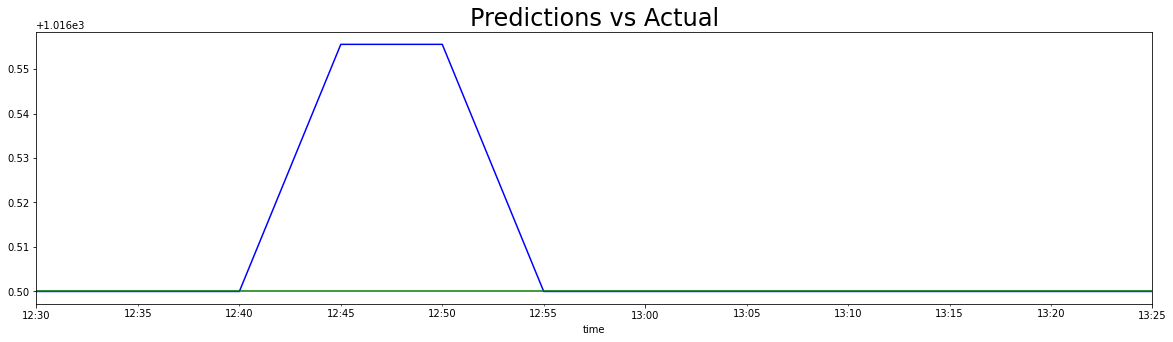

ABSOLUTE ERROR 0.00925925937636407
MSE 0.000514403288929182


In [52]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.pressure[:end_pred].plot(figsize = (20,5),color = "blue")
df_forecast.plot(color = "green")
plt.title("Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.pressure[:end_pred], df_forecast)))
print("MSE "+str(mean_squared_error(df_test.pressure[:end_pred], df_forecast)))

In [33]:
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(seasonal=[288]) #[0,6,12]

In [34]:
import numpy as np

ts = df.copy()

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    print(j)
    try:
        cg = cfg_list[j]
        print(cg)
        t,d,s,p,b,r = cg
        train = df_train.humidity.copy()
        test = df_test.humidity.copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(train, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(end_pred)
        print('ok')
        rmse = mean_squared_error(test[:end_pred],y_forecast)
        print('rmse ',rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
       continue



Holt's Winter Model
0
['add', True, 'add', 288, True, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  3.4594643880476306
1
['add', True, 'add', 288, True, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  3.465501001142249
2
['add', True, 'add', 288, False, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  4.635259101321859
3
['add', True, 'add', 288, False, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  4.640443786844335
4
['add', True, 'mul', 288, True, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  3.111345763928234
5
['add', True, 'mul', 288, True, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  3.1165183433087384
6
['add', True, 'mul', 288, False, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.2247057433393564
7
['add', True, 'mul', 288, False, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.227168777206668
8
['add', True, None, 288, True, True]
ok
rmse  1.111701939460289
9
['add', True, None, 288, True, False]
ok
rmse  1.1079708238016408
10
['add', True, None, 288, False, True]
ok
rmse  1.1382051399375024
11
['add', True, None, 288, False, False]
ok
rmse  1.135456582374397
12
['add', False, 'add', 288, True, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.099572389460861
13
['add', False, 'add', 288, True, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.1118232495195857
14
['add', False, 'add', 288, False, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.501605239834806
15
['add', False, 'add', 288, False, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.5078852118305686
16
['add', False, 'mul', 288, True, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  1.6246393638521415
17
['add', False, 'mul', 288, True, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  1.630517685142969
18
['add', False, 'mul', 288, False, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  1.1041058442523273
19
['add', False, 'mul', 288, False, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  1.103569714632413
20
['add', False, None, 288, True, True]
ok
rmse  0.05503201207796979
21
['add', False, None, 288, True, False]
ok
rmse  0.054573033044844656
22
['add', False, None, 288, False, True]
ok
rmse  0.06134192789399925
23
['add', False, None, 288, False, False]
ok
rmse  0.06138296694045178
24
['mul', True, 'add', 288, True, True]
ok
rmse  15.982037967078123
25
['mul', True, 'add', 288, True, False]
ok
rmse  16.009402481602347
26
['mul', True, 'add', 288, False, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  18.377436992528647
27
['mul', True, 'add', 288, False, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  18.433898624709958
28
['mul', True, 'mul', 288, True, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
29
['mul', True, 'mul', 288, True, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  15.919917849080356
30
['mul', True, 'mul', 288, False, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:895: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:898: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))
/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:899: RuntimeWarning: invalid value encountered in power
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \
/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:905: RuntimeWarning: invalid value 

ok
31
['mul', True, 'mul', 288, False, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:895: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:898: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))
/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:899: RuntimeWarning: invalid value encountered in power
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \
/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:905: RuntimeWarning: invalid value 

ok
32
['mul', True, None, 288, True, True]
ok
33
['mul', True, None, 288, True, False]
ok
rmse  1.1046829489796843
34
['mul', True, None, 288, False, True]
ok
rmse  1.1432422216052502
35
['mul', True, None, 288, False, False]
ok
rmse  1.125385321568007
36
['mul', False, 'add', 288, True, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  3.289852626148882
37
['mul', False, 'add', 288, True, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  3.3247463496020875
38
['mul', False, 'add', 288, False, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  18.389511615144556
39
['mul', False, 'add', 288, False, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  18.44611053535385
40
['mul', False, 'mul', 288, True, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  1.5308692022774404
41
['mul', False, 'mul', 288, True, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  1.541419024208305
42
['mul', False, 'mul', 288, False, True]
ok
rmse  1.8719273002878387
43
['mul', False, 'mul', 288, False, False]
ok
rmse  1.867288592280311
44
['mul', False, None, 288, True, True]
ok
rmse  0.054237346908928834
45
['mul', False, None, 288, True, False]
ok
rmse  0.05381382051135853
46
['mul', False, None, 288, False, True]
ok
rmse  0.05072489782188944
47
['mul', False, None, 288, False, False]
ok
rmse  0.05044598216958194
48
[None, True, 'add', 288, True, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.2979572244375004
49
[None, True, 'add', 288, True, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.3040225914231396
50
[None, True, 'add', 288, False, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  3.1806646692666196
51
[None, True, 'add', 288, False, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  3.1874069027839393
52
[None, True, 'mul', 288, True, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.075796824696662
53
[None, True, 'mul', 288, True, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.081203686136402
54
[None, True, 'mul', 288, False, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  1.3338151663711795
55
[None, True, 'mul', 288, False, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  1.3384309884229537
56
[None, True, None, 288, True, True]
ok
rmse  1.534815460182622
57
[None, True, None, 288, True, False]
ok
rmse  1.5275000000000245
58
[None, True, None, 288, False, True]
ok
rmse  1.534812289101448
59
[None, True, None, 288, False, False]
ok
rmse  1.5274999999999945
60
[None, False, 'add', 288, True, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.2979572244375004
61
[None, False, 'add', 288, True, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.3040225914231396
62
[None, False, 'add', 288, False, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  3.1806646692666196
63
[None, False, 'add', 288, False, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  3.1874069027839393
64
[None, False, 'mul', 288, True, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.075796824696662
65
[None, False, 'mul', 288, True, False]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  2.081203686136402
66
[None, False, 'mul', 288, False, True]


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


ok
rmse  1.3338151663711795
67
[None, False, 'mul', 288, False, False]
ok
rmse  1.3384309884229537
68
[None, False, None, 288, True, True]
ok
rmse  1.534815460182622
69
[None, False, None, 288, True, False]
ok
rmse  1.5275000000000245
70
[None, False, None, 288, False, True]
ok
rmse  1.534812289101448
71
[None, False, None, 288, False, False]
ok
rmse  1.5274999999999945


/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


In [35]:
print(best_RMSE, best_config)

0.05044598216958194 ['mul', False, None, 288, False, False]


In [37]:
model = ExponentialSmoothing(df_train.humidity,  trend='add', damped=False, seasonal=None, seasonal_periods=288)
model_fit = model.fit(optimized=True, use_boxcox=False, remove_bias=False)
print(model_fit.summary())
df_forecast = model_fit.forecast(end_pred)
mse = mean_squared_error(df_test.temperature[:end_pred],y_forecast)
print('mse ',mse)


#    t_params = ['add', 'mul', None]
#    d_params = [True, False]
#    s_params = ['add', 'mul', None]
#    p_params = seasonal
#    b_params = [True, False]
#    r_params = [True, False]

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2304
Model:             ExponentialSmoothing   SSE                             83.248
Optimized:                         True   AIC                          -7642.620
Trend:                         Additive   BIC                          -7619.650
Seasonal:                          None   AICC                         -7642.583
Seasonal Periods:                  None   Date:                 Thu, 16 Jul 2020
Box-Cox:                          False   Time:                         14:38:54
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_slope            0.45977